In [2]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Deep Neural Network

## Session 8a - Different regularization methods
## FIFA dataset 

<img src='../../../images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [3]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np # type: ignore
import pandas as pd # type: ignore

from collections.abc import Callable
from typing import Literal

from sklearn.model_selection import train_test_split # type: ignore
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay # type: ignore
from sklearn.preprocessing import StandardScaler # type: ignore
import matplotlib.pyplot as plt # type: ignore

import tensorflow as tf # type: ignore


# os.chdir("/home/pgdai/Desktop/DNN-May24/study material-20240518T025337Z-001/study material/utils")
# from utils.helper import fn_plot_torch_hist, fn_plot_confusion_matrix

2024-05-23 15:48:43.256983: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-23 15:48:43.303469: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-23 15:48:43.303510: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-23 15:48:43.304702: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-23 15:48:43.312185: I tensorflow/core/platform/cpu_feature_guar

In [4]:

###----------------------
### Plot confusion matrix
###----------------------
def fn_plot_confusion_matrix(y_true, y_pred, labels):
    '''
    Args:
        y_true: Ground Truth 
        y_pred : Predictions
        labels : dictonary 
                  {0: 'Goal Keeper', 
                  1: 'Defender', 
                  2: 'Mid-Fielder', 
                  3: 'Forward'}
    
    '''
    
    cm  = confusion_matrix(y_true, y_pred)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=labels.values())
    
    fig, ax = plt.subplots(figsize = (6,6))
    
    disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)
    # Disable the grid
    ax.grid(False)

    plt.show();

In [5]:

###------------------------------
### Plot Loss Curve using pytorch
###------------------------------
def fn_plot_torch_hist(hist_df):
    
    # instantiate figure
    fig, axes = plt.subplots(1,2 , figsize = (15,6))
    
    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='cyan', alpha=0.5)

    # columns
    x = hist_df.columns[0]
    y1 = hist_df.columns[1]
    y2 = hist_df.columns[2]
    y3 = hist_df.columns[3]
    y4 = hist_df.columns[4]
    
    # Where was min loss
    best = hist_df[hist_df[y2] == hist_df[y2].min()]
    best = best.drop_duplicates(subset=y2)
    # pick first axis
    ax = axes[0]

    # Plot all losses
    hist_df.plot(x = x, y = [y1, y2], ax = ax)

    # calculate offset for arroe
    y_min = min(hist_df[y1].min(), hist_df[y2].min())
    y_max = max(hist_df[y1].max(), hist_df[y2].max())
    offset = (y_max-y_min)/10.0

    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y2]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    
    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y2].to_numpy()[0]:6.4f}', # text to print
                xy=(best[x].to_numpy(), best[y2].to_numpy()[0]), # Arrow start
                xytext=(best[x].to_numpy()+ offset, best[y2].to_numpy()[0]+offset), # location of text 
                fontsize=14,va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor='cyan', shrink=0.05)) # arrow
    
    # Draw vertical line at best value
    ax.axvline(x = best[x].to_numpy(), color = 'green', linestyle='-.', lw = 3);
    
    ax.set_xlabel(x.title())
    ax.set_ylabel(y1.title())
    ax.set_title('Errors')
    ax.grid()
    ax.legend(loc = 'upper left') # model legend to upper left

    # pick second axis
    ax = axes[1]

    # Plot accuracies
    hist_df.plot(x = x, y = [y3, y4], ax = ax)

    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y3],
                           hist_df.iloc[-1][y4]) #text to plot
        
    # calculate offset for arroe
    y_min = min(hist_df[y3].min(), hist_df[y4].min())
    y_max = max(hist_df[y3].max(), hist_df[y4].max())
    offset = (y_max-y_min)/10.0

    # place a text box in lower middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best[x].to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best[x].to_numpy()- offset, best[y4].to_numpy()[0]-offset), # location of text 
                fontsize=14,va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor='cyan', shrink=0.05)) # arrow
    
    
    # Draw a vertical line at best value
    ax.axvline(x = best[x].to_numpy(), 
               color = 'green', 
               linestyle='-.', lw = 3)
    
    # Labels
    ax.set_xlabel(x.title())
    ax.set_ylabel(y3.title())
    ax.set_title('Accuracies')
    ax.grid();
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()


In [6]:
###------------------------------------------------
### Plot Loss Curve using Tensorflow history object
###------------------------------------------------
def fn_plot_tf_hist(hist_df):
    
    '''
    Args:
        hist_df: a dataframe with following ccolumns
            column 0: loss
            column 1: accuracy
            column 2: val_loss
            column 3: val_accuracy
            While plotting columns are accessed by index 
            so that even if the column names are different it will not throw exceptions.
    '''
        
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    CMAP = plt.cm.coolwarm
    
    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y3] == hist_df[y3].min()]
    
    ax = axes[0]

    hist_df.plot(y = [y1,y3], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot
    
    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)
    
    # calculate offset for arroe
    y_min = min(hist_df[y1].min(), hist_df[y3].min())
    y_max = max(hist_df[y1].max(), hist_df[y3].max())
    offset = (y_max-y_min)/10.0
    
    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y3].to_numpy()[0] + offset), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.set_title('Errors')
    ax.grid();
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y2, y4], ax = ax, colormap=CMAP)
    
    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # calculate offset for arroe
    y_min = min(hist_df[y2].min(), hist_df[y4].min())
    y_max = max(hist_df[y2].max(), hist_df[y4].max())
    offset = (y_max-y_min)/10.0

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y4].to_numpy()[0]-offset), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
    
    
    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.grid()
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()
    


In [7]:
print (fn_plot_torch_hist.__doc__)

None


In [8]:
print (fn_plot_confusion_matrix.__doc__)


    Args:
        y_true: Ground Truth 
        y_pred : Predictions
        labels : dictonary 
                  {0: 'Goal Keeper', 
                  1: 'Defender', 
                  2: 'Mid-Fielder', 
                  3: 'Forward'}
    
    


In [9]:
###----------------------
### Some basic parameters
###----------------------

#Directories so that we can save the trained model, the outputs and the inputs
inpDir = '/home/pgdai/Desktop/March24-DAI-Workspace/DNN-May24/LectureThings/Day7/input'
outDir = '../../../output'
modelDir = '../../../models'
subDir = 'fifa_2019'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE)
rng = np.random.default_rng(seed = RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 101 # number of epochs
BATCH_SIZE = 32 #default of tensorflow
ALPHA = 0.001 # learning rate
TEST_SIZE = 0.2
REG_LAMBDA = 0.001

L1_LAMBDA= 0.001
L2_LAMBDA= 0.001

# parameters for Matplotlib
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'medium',
          'axes.titlesize':'large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }

plt.rcParams.update(params)

CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

## Basic Hygiene

In [10]:
# Check if all directories are present
if not os.path.exists(os.path.join(outDir)):
    os.makedirs(os.path.join(outDir))
    print ('Created {} directory'.format(outDir))

if not os.path.exists(os.path.join(modelDir, subDir)):
    os.makedirs(os.path.join(modelDir, subDir))
    print ('Created {} directory'.format(os.path.join(modelDir, subDir)))

Created ../../../output directory
Created ../../../models/fifa_2019 directory


## Read FIFA 2019 data set

In [11]:
data_df = pd.read_csv(os.path.join(inpDir, 'fifa_2019.csv'))
data_df.shape

(18207, 89)

In [12]:
for col in data_df.columns:
    print(f"{col}: {data_df[col].unique}")

Unnamed: 0: <bound method Series.unique of 0            0
1            1
2            2
3            3
4            4
         ...  
18202    18202
18203    18203
18204    18204
18205    18205
18206    18206
Name: Unnamed: 0, Length: 18207, dtype: int64>
ID: <bound method Series.unique of 0        158023
1         20801
2        190871
3        193080
4        192985
          ...  
18202    238813
18203    243165
18204    241638
18205    246268
18206    246269
Name: ID, Length: 18207, dtype: int64>
Name: <bound method Series.unique of 0                  L. Messi
1         Cristiano Ronaldo
2                 Neymar Jr
3                    De Gea
4              K. De Bruyne
                ...        
18202          J. Lundstram
18203    N. Christoffersson
18204             B. Worman
18205        D. Walker-Rice
18206             G. Nugent
Name: Name, Length: 18207, dtype: object>
Age: <bound method Series.unique of 0        31
1        33
2        26
3        27
4        27
         ..


In [13]:
# removing rows with position = null
data_df = data_df[data_df["Position"].notnull()]
data_df.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [14]:
data_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,18147.0,9089.239599,5257.923360,0.0,4536.5,9076.0,13662.5,18206.0
ID,18147.0,214279.818868,29970.319078,16.0,200305.5,221740.0,236512.5,246620.0
Age,18147.0,25.121122,4.669796,16.0,21.0,25.0,28.0,45.0
Overall,18147.0,66.253926,6.913320,46.0,62.0,66.0,71.0,94.0
Potential,18147.0,71.324076,6.132286,48.0,67.0,71.0,75.0,95.0
Special,18147.0,1598.002645,272.882706,731.0,1457.0,1635.0,1787.0,2346.0
International Reputation,18147.0,1.113297,0.394150,1.0,1.0,1.0,1.0,5.0
Weak Foot,18147.0,2.947154,0.660498,1.0,3.0,3.0,3.0,5.0
Skill Moves,18147.0,2.361492,0.756274,1.0,2.0,2.0,3.0,5.0
Jersey Number,18147.0,19.546096,15.947765,1.0,8.0,17.0,26.0,99.0


In [15]:
data_df['Position'].isnull().sum()

0

In [16]:
# Following columns appear to be relevant for our analysis
rel_cols = ["Position", 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
            'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
            'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
            'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
            'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
            'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
            'GKKicking', 'GKPositioning', 'GKReflexes']

In [17]:
class_labels = {0: 'Goal Keeper', 1: 'Defender', 2: 'Mid-Fielder', 3: 'Forward'}

In [18]:
goalkeeper = 'GK'
forward = ['ST', 'LW', 'RW', 'LF', 'RF', 'RS','LS', 'CF']
midfielder = ['CM','RCM','LCM', 'CDM','RDM','LDM', 'CAM', 'LAM', 'RAM', 'RM', 'LM']
defender = ['CB', 'RCB', 'LCB', 'LWB', 'RWB', 'LB', 'RB']

In [19]:
#Assign labels to goalkeepers
data_df.loc[data_df["Position"] == "GK", "Position"] = 0

#Defenders
data_df.loc[data_df["Position"].isin(defender), "Position"] = 1

#Midfielders
data_df.loc[data_df["Position"].isin(midfielder), "Position"] = 2

#Forward
data_df.loc[data_df["Position"].isin(forward), "Position"] = 3

# Convert Column "Position" to numeric so that Pandas does not complain
data_df['Position'] = pd.to_numeric(data_df['Position'], downcast="integer")

In [20]:
data_df = data_df[rel_cols]
data_df.head()

,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,3,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,3,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,3,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,2,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [21]:
labels = {0: 'Goal Keeper', 1: 'Defender', 2: 'Mid-Fielder', 3: 'Forward'}

In [22]:
features_df = data_df.drop("Position", axis = 1)
labels = data_df['Position']

In [23]:
# splitting in train ans test datasets
X_train, X_test, y_train, y_test = train_test_split(features_df, labels,
                                     stratify=labels,
                                     test_size=TEST_SIZE, 
                                     random_state=RANDOM_STATE )
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14517, 33), (3630, 33), (14517,), (3630,))

In [24]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train)

X_test = sc.transform(X_test)

In [25]:
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

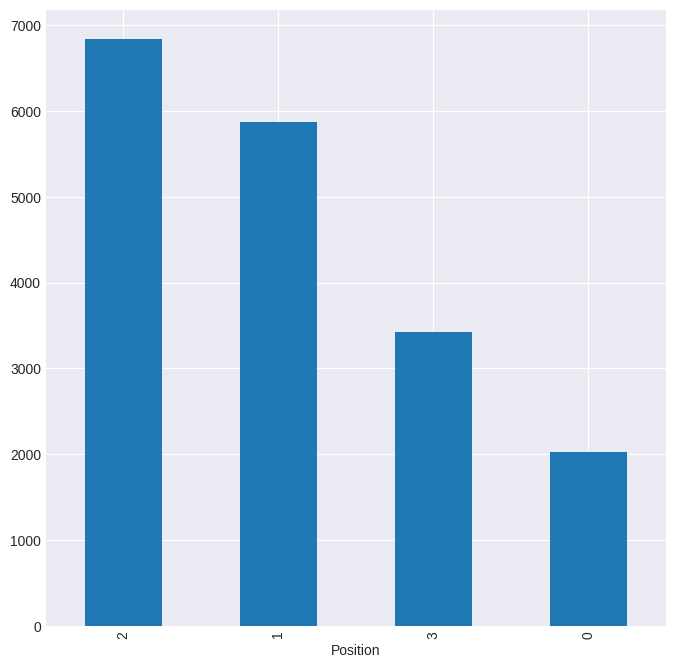

In [26]:
fig = plt.figure(figsize=(8,8))
data_df['Position'].value_counts().plot(kind = "bar");

In [27]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14517, 33), (3630, 33), (14517,), (3630,))

# Prepare Model

https://www.tensorflow.org/api_docs/python/tf/keras/layers/InputLayer

In [28]:
# tf.keras.layers.InputLayer(
#     shape=None,
#     batch_size=None,
#     dtype=None,
#     sparse=None,
#     batch_shape=None,
#     input_tensor=None,
#     name=None,
#     **kwargs
# )

In [29]:
k_init = tf.keras.initializers.GlorotUniform(seed=RANDOM_STATE)
k_reg = tf.keras.regularizers.L1L2(l1=L1_LAMBDA, l2=L2_LAMBDA)

## Implement L2

- To implement Kernal Regularizer:
- Lasso - l1
- Ridge - l2
- Elastic Net - l1l2

In [30]:
# # Calling class Sequential and pass all layers as a list
# model = tf.keras.models.Sequential([
#   tf.keras.layers.InputLayer(input_shape = [33,]),
#   tf.keras.layers.Dense(33, activation='relu', kernel_initializer = k_init, kernel_regularizer = 'l2'),
#   # tf.keras.layers.ReLU(),
#   tf.keras.layers.Dense(23, activation='relu', kernel_initializer = k_init, kernel_regularizer = 'l2'),
#   tf.keras.layers.Dense(12, activation='relu', kernel_initializer = k_init, kernel_regularizer = 'l2'),
#   tf.keras.layers.Dense(4, activation='relu', kernel_initializer = k_init, kernel_regularizer = 'l2'),
#   tf.keras.layers.Dense(4)
# ])

In [31]:
# Calling class Sequential and pass all layers as a list
# do1=0.05
# do2=0.10
# do3=0.15
# do4=0.20
model = tf.keras.models.Sequential([
    ### -----------------
    ### Input Layer
    ### -----------------
  tf.keras.layers.InputLayer(input_shape = [33,]),
    ### -----------------
    ### Set 1
    ### -----------------
  tf.keras.layers.Dense(33,  kernel_initializer = k_init, kernel_regularizer = k_reg),
  #BN Layer
  tf.keras.layers.BatchNormalization(),
  # ReLU as Layer
  tf.keras.layers.ReLU(),
  #tf.keras.layers.Dropout(do1),
  # tf.keras.layers.ReLU(),
     ### -----------------
    ### Set 2
    ### -----------------
  tf.keras.layers.Dense(23, kernel_initializer = k_init, kernel_regularizer = k_reg),
  #BN Layer
  tf.keras.layers.BatchNormalization(),
  # ReLU as Layer
  tf.keras.layers.ReLU(),
  #tf.keras.layers.Dropout(do2),
     ### -----------------
    ### set 3
    ### -----------------
  tf.keras.layers.Dense(12, kernel_initializer = k_init, kernel_regularizer = k_reg),
  #BN Layer
  tf.keras.layers.BatchNormalization(),
  # ReLU as Layer
  tf.keras.layers.ReLU(),
  #tf.keras.layers.Dropout(do3),
     ### -----------------
    ### Set 4
    ### -----------------
  tf.keras.layers.Dense(4, kernel_initializer = k_init, kernel_regularizer = k_reg),
  #BN Layer
  tf.keras.layers.BatchNormalization(),
  # ReLU as Layer
  tf.keras.layers.ReLU(),
  #tf.keras.layers.Dropout(do4),
  tf.keras.layers.Dense(4)
])

2024-05-23 15:48:48.421286: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [32]:
model(X_train[:1])

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[ 0.09121107, -0.06252214,  0.00471913, -0.21968904]],
      dtype=float32)>

In [33]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=ALPHA)

In [34]:
model.compile(optimizer=optimizer,loss=loss_fn,metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_data=[X_test,y_test], batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=2)

Epoch 1/101
454/454 - 5s - loss: 1.0972 - accuracy: 0.7983 - val_loss: 0.7830 - val_accuracy: 0.8570 - 5s/epoch - 11ms/step
Epoch 2/101
454/454 - 3s - loss: 0.6890 - accuracy: 0.8553 - val_loss: 0.5833 - val_accuracy: 0.8730 - 3s/epoch - 6ms/step
Epoch 3/101
454/454 - 3s - loss: 0.5627 - accuracy: 0.8613 - val_loss: 0.5060 - val_accuracy: 0.8719 - 3s/epoch - 6ms/step
Epoch 4/101
454/454 - 3s - loss: 0.5018 - accuracy: 0.8624 - val_loss: 0.4507 - val_accuracy: 0.8711 - 3s/epoch - 6ms/step
Epoch 5/101
454/454 - 3s - loss: 0.4662 - accuracy: 0.8611 - val_loss: 0.4265 - val_accuracy: 0.8749 - 3s/epoch - 6ms/step
Epoch 6/101
454/454 - 3s - loss: 0.4396 - accuracy: 0.8654 - val_loss: 0.4163 - val_accuracy: 0.8697 - 3s/epoch - 6ms/step
Epoch 7/101
454/454 - 2s - loss: 0.4246 - accuracy: 0.8625 - val_loss: 0.3948 - val_accuracy: 0.8733 - 2s/epoch - 5ms/step
Epoch 8/101
454/454 - 2s - loss: 0.4150 - accuracy: 0.8632 - val_loss: 0.3823 - val_accuracy: 0.8736 - 2s/epoch - 5ms/step
Epoch 9/101
454

In [35]:
loss_df = pd.DataFrame(history.history)
loss_df.head()

,loss,accuracy,val_loss,val_accuracy
0,1.097160,0.798305,0.783016,0.857025
1,0.689047,0.855273,0.583262,0.873003
2,0.562700,0.861335,0.505984,0.871901
3,0.501768,0.862437,0.450684,0.871074
4,0.466211,0.861128,0.426468,0.874931


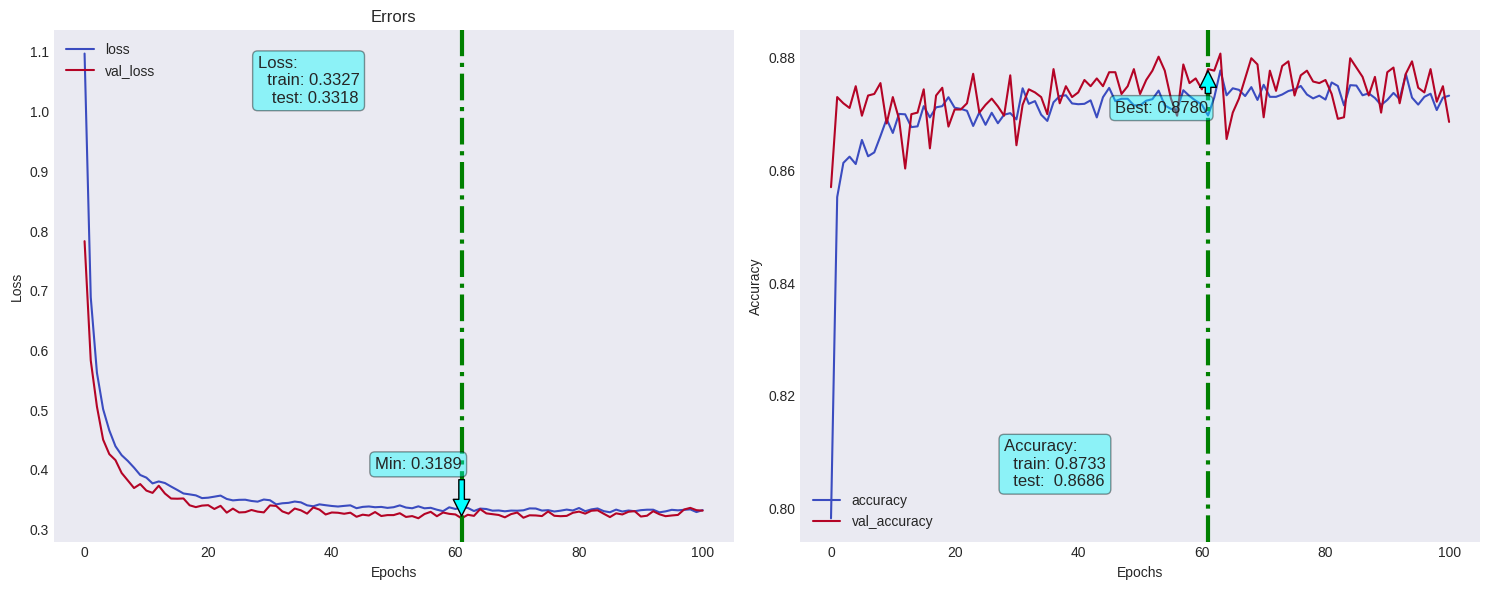

In [36]:
fn_plot_tf_hist(loss_df)


# the red line should follow the blue line as closely as poosible till the end. At the end, it should diverge a bit

In [37]:
loss_df[loss_df['val_loss'] == loss_df['val_loss'].min()]

,loss,accuracy,val_loss,val_accuracy
61,0.337174,0.869739,0.318887,0.877961
